## Fixed parameter search

This notebook is intendend to find the best matching values for fixed parameters to be used in the simulation.

These parameters include:
- Distribution of time between orders.
    - Probably exponential distribution, extension of Poisson dist
- Distribution of token size of trades
    - Possibly different for buy and sell orders
- Buy or Sell order
    - Some function of past X trades completed. This is undecided yet.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from scipy.stats import kstest, expon
from scipy.stats import halfgennorm, pareto, exponnorm, lognorm
from fitter import Fitter, get_common_distributions, get_distributions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.special import expit, logit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

pair_list = [
            ("AGIX-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0xe45b4a84e0ad24b8617a489d743c52b84b7acebe", 40),
            ("HEX-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0x55d5c232d921b9eaa6b37b5845e439acd04b4dba", 100),
            ("OPTIMUS-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0x8de7a9540e0edb617d78ca5a7c6cc18295fd8bb9", 70),
            ("SHIB-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0x811beed0119b4afce20d2583eb608c6f7af1954f", 50),
            ("SHIK-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0x0b9f5cef1ee41f8cccaa8c3b4c922ab406c980cc", 60),
            ("BabyDoge-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0xc736ca3d9b1e90af4230bd8f9626528b3d4e0ee0", 180),
            ("FLOKI-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0x231d9e7181e8479a8b40930961e93e7ed798542c", 180),
            ("INJ-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0x1bdcebca3b93af70b58c41272aea2231754b23ca", 60),
            ("MBOX-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0x8fa59693458289914db0097f5f366d771b7a7c3f", 90),
            ("VOLT-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0x487bfe79c55ac32785c66774b597699e092d0cd9", 200)
            ]

In [2]:
def load_csv_to_df(file_path, verbose=False, name=""):
    # Load CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # If verbose mode is enabled, print the dataset name, number of rows, and some datetime information
    if verbose:
        #print(name)
        print("Number of rows:", len(df))
        print("Last datetime:", df.datetime.iloc[-2], )  # Assuming there is a "datetime" column in the DataFrame
        print("First datetime:", df.datetime.iloc[0])
        print("Time difference (in days):", datetime.strptime(df.datetime.iloc[0], '%Y-%m-%d %H:%M:%S') - datetime.strptime(df.datetime.iloc[-5], '%Y-%m-%d %H:%M:%S'))
        print()
    
    # Return the DataFrame
    return df

def set_index(df, info=False):
    # Convert 'datetime' column to datetime type and set it as the index
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    
    if info:
        # Print some information about the resulting DataFrame
        df.info()

In [3]:
%%script false
##Part 1 - The time spacing
table_dists = []
for pair in pair_list:
    #geting name of current pair and folder location
    name = pair[0]
    #print(name)
    # if name == "FLOKI-WBNB":
    #     continue
    print(f"~~~---{name}---~~~")
    file_path = f"D:/Dokumenty/Vejška/Magisterské studium/DIPLOMKA/Code_and_Data/Data_scraping/DEX_data_scraper/complete_data/{name}/{name}_complete.csv"

    #loading data without werbose printout, seting index
    df = load_csv_to_df(file_path, verbose=False, name = name)
    set_index(df, info=False)


    #compute the spacing between variables
    spacing = np.diff(df.index).astype('timedelta64[s]').astype(int) *-1

    #Cropping data to 99th percentile
    percentile_99 = np.percentile(spacing, 99)
    spacing_99 = [val for val in spacing if val <= percentile_99]

    basic_expon = False
    if basic_expon:
        param = expon.fit(spacing_99)
        print(param)

        statistic, p_value = kstest(spacing_99, 'expon', args=param)

        # Print the p-value
        print("The p-value is:", p_value)

    fitter_dist_fitting = True
    if fitter_dist_fitting:
        #dists = get_common_distributions()
        #dists.append('exponweib')
        #dists = get_distributions()
        # dists = ['gamma',
        #         'lognorm',
        #         "beta",
        #         "burr",
        #         "norm",
        #         "expon", 
        #         "exponnorm", 
        #         "exponpow",
        #          "exponweib",
        #          "truncexpon",
        #          "pareto",
        #          "cauchy",
        #          "gumbel_r",
        #          "laplace"]

        ###Candidate distributions selected based on running all dists on several tokens
        d = get_common_distributions()
        d.extend(['halfgennorm', 'johnsonsb', 'fatiguelife', 'lognorm', 'pareto'])
        d.extend(['lognorm', 'invgauss', 'fatiguelife', 'halfgennorm', 'invgamma'])
        d.extend(['fatiguelife', 'halfgennorm', 'johnsonsb', 'lognorm', 'invgauss'])
        d.extend(['halfgennorm', 'beta', 'fatiguelife', 'pareto', 'geninvgauss'])
        d.extend(['burr12', 'pareto', 'halfgennorm', 'invgauss', 'lognorm'])
        d.extend(['gumbel_r', 'halflogistic', 'moyal', 'laplace', 'hypsecant'])
        d.extend(['gilbrat', 'gibrat', 'expon', 'laplace_asymmetric', 'exponnorm'])
        d.extend(['invgauss', 'beta', 'levy', 'halfgennorm', 'halfcauchy'])
        d.extend(['gennorm', 'pareto', 'invgauss', 'halfcauchy', 'invgamma'])
        d.extend(['halflogistic', 'moyal', 'gumbel_r', 'laplace_asymmetric', 'gompertz'])

        dists = list(set(d))

        #dists = ['expon', 'pareto', 'halfgennorm']
        #dists = ['halfgennorm']
        #dists = ['pareto']
        #dists = ['expon']

        #dists = get_distributions()

        f = Fitter(spacing,
           distributions=dists)
        f.fit()
        
        try:
            print(f.get_best())   
        except:
            pass                                    
        # print(f.summary())
        # plt.show()

        Nbest = 5
        ###Try to get x best dists
        names = f.df_errors.sort_values(
                    by="bic").index[0:Nbest].values
        
        print(names)
        
        
    
        do_dist_table = False
        if do_dist_table:
            row = [name[:-5]]
            for element in dists:
                if element in names:
                    row.append(1)
                else:
                    row.append(" ")
            table_dists.append(row)
            #print(names)

        

        ##Search on all distributions, with restarted runs and full samples
        #AGIX
        #['halfgennorm' 'johnsonsb' 'fatiguelife' 'lognorm' 'pareto']
        #HEX
        #['lognorm' 'invgauss' 'fatiguelife' 'halfgennorm' 'invgamma']
        #Optimus
        #['fatiguelife' 'halfgennorm' 'johnsonsb' 'lognorm' 'invgauss']
        #SHIB
        #['halfgennorm' 'beta' 'fatiguelife' 'pareto' 'geninvgauss']
        #SHIK
        #['burr12' 'pareto' 'halfgennorm' 'invgauss' 'lognorm']
        #BabyDoge
        #['gumbel_r' 'halflogistic' 'moyal' 'laplace' 'hypsecant']
        #FLOKI
        #['gilbrat' 'gibrat' 'expon' 'laplace_asymmetric' 'exponnorm']
        #INJ
        #['invgauss' 'beta' 'levy' 'halfgennorm' 'halfcauchy']
        #MBOX
        #['gennorm' 'pareto' 'invgauss' 'halfcauchy' 'invgamma']
        #VOLT
        #['halflogistic' 'moyal' 'gumbel_r' 'laplace_asymmetric' 'gompertz']


        ###OLD RUNS - only some tokens
        #lets try three runs on the first token
        #run 1: ['johnsonsb', 'fatiguelife', 'exponweib', 'gengamma', 'halfgennorm'] (not restarted)
        #run 2: ['pareto', 'expon', 'halflogistic', 'cauchy', 'moyal'] (restarted)
        #run 3: ['fatiguelife', 'exponweib', 'gengamma', 'halfgennorm', 'lognorm'] (not restarted)
        #run 4: ['fatiguelife' 'exponweib' 'gengamma' 'halfgennorm' 'levy'] (restarted + bic selection)

        ##Two runs on OPTIMUS
        #run 1: ['invgauss', 'betaprime', 'halfcauchy', 'fatiguelife', 'genextreme'] (restarted)
        #run 2: ['invgauss', 'betaprime', 'halfcauchy', 'fatiguelife', 'genextreme'] (restarted)
        #run 3: ['pareto', 'expon', 'cauchy', 'moyal', 'gumbel_r'] (not restarted)

        ##Two runs at FLOKI
        #run 1: ['f', 'kappa3', 'alpha', 'beta', 'bradford'] (restarted)
        #run 2: ['expon', 'cauchy', 'laplace', 'gumbel_r', 'logistic'] (not restarted)

if do_dist_table:        
    table_dists = pd.DataFrame(table_dists)
    #table_dists.set_index(table_dists.iloc[:, 0], inplace=True)
    #table_dists.columns = ["Token"].extend(dists)
    colnames = list(["Token"])
    colnames.extend(dists)
    table_dists.columns = colnames
    #print(table_dists)
    #table_dists.to_csv(r"D:\Dokumenty\Vejška\Magisterské studium\DIPLOMKA\Tables\Simulation_Timing_distributions_scores.csv", index=False)

    

Couldn't find program: 'false'


In [4]:
%%script false
for pair in pair_list:
    #geting name of current pair and folder location
    name = pair[0]
    #print(name)
    # if name == "FLOKI-WBNB":
    #     continue
    print(f"~~~---{name}---~~~")
    file_path = f"D:/Dokumenty/Vejška/Magisterské studium/DIPLOMKA/Code_and_Data/Data_scraping/DEX_data_scraper/complete_data/{name}/{name}_complete.csv"

    #loading data without werbose printout, seting index
    df = load_csv_to_df(file_path, verbose=False, name = name)
    set_index(df, info=False)


    #compute the spacing between variables
    spacing = np.diff(df.index).astype('timedelta64[s]').astype(int) *-1

    #Cropping data to 99th percentile
    percentile_99 = np.percentile(spacing, 99)
    spacing_99 = [val for val in spacing if val <= percentile_99]


    #Try to compare data with random sample from the fitted distributions
    #r = halfgennorm.rvs(beta = 0.4, loc=0, scale=4, size=5000)#This is how to draw random sample from halfgennorm - this will be my setting number one, it fits many distributions well (only first parameter decides about shape of dist., seconf is always 0 and third about size)
    #r = pareto.rvs(b = 2.5, loc=-80, scale=80, size=5000) #This I guess will by my second distribution
    r = expon.rvs(loc = 0, scale=300, size = 5000) #And this could be the third one
    #
    #{'pareto': {'b': 6.793733998573082, 'loc': -400.09425046951173, 'scale': 400.0942504695117}
    #{'expon': {'loc': 0.0, 'scale': 306.1414913957935}}
    

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    axes[0].hist(spacing, bins=100, color='blue', edgecolor='black')
    axes[0].set_title(f'{name} Histogram of Spacing between Observations')

    axes[1].hist(r, bins=100, color='red', edgecolor='black')
    axes[1].set_title('Random sample')
    
    #plt.hist(spacing_99, bins=100, edgecolor='black')
    plt.show()

Couldn't find program: 'false'


In [5]:
%%script false
###Part 2 - distribution of order size
table_dists = []
for pair in pair_list:
    #geting name of current pair and folder location
    name = pair[0]
    #print(name)
    # if name == "FLOKI-WBNB":
    #     continue
    print(f"~~~---{name}---~~~")
    file_path = f"D:/Dokumenty/Vejška/Magisterské studium/DIPLOMKA/Code_and_Data/Data_scraping/DEX_data_scraper/complete_data/{name}/{name}_complete.csv"

    #loading data without werbose printout, seting index
    df = load_csv_to_df(file_path, verbose=False, name = name)
    set_index(df, info=False)

    log_amount_token = np.log10(df.amount_token)
    log_total_native = np.log10(df.total_native)

    percentile_99_swap = np.percentile(df.amount_token, 100)
    swap_99 = [val for val in df.amount_token if val <= percentile_99_swap]

    ##Distribution fitting
    #dists = get_common_distributions()
    #dists = get_distributions()
    ###Candidate distributions selected based on running all dists on all tokens
    # d = get_common_distributions()
    # d.extend(['halfgennorm', 'burr12', 'pareto', 'genpareto', 'fisk'])
    # d.extend(['halflogistic', 'gumbel_r', 'genlogistic', 'moyal', 'expon'])
    # d.extend(['halfcauchy', 'foldcauchy', 'genpareto', 'pareto', 'invgamma'])
    # d.extend(['exponnorm', 'expon', 'genexpon', 'moyal', 'halflogistic'])
    # d.extend(['pareto', 'expon', 'cauchy', 'powerlaw', 'laplace'])

    # d.extend(['halfnorm', 'foldnorm', 'rayleigh', 'maxwell', 'kstwobign'])
    # d.extend(['halflogistic', 'expon', 'laplace_asymmetric', 'exponnorm', 'gumbel_r'])
    # d.extend(['dgamma', 'dweibull', 'foldcauchy', 'laplace', 'cauchy'])
    # d.extend(['gilbrat', 'gibrat', 'exponnorm', 'expon', 'laplace_asymmetric'])
    # d.extend(['exponnorm', 'genlogistic', 'beta', 'betaprime', 'maxwell'])
    # dists = list(set(d))

    #dists = ['expon', 'exponnorm', 'lognorm', 'pareto']
    #dists = ['exponnorm']
    dists = ['lognorm']

    f = Fitter(df.amount_token,
           distributions=dists)
    f.fit()
    try:
        print(f.get_best())     
    except:
        pass                                    
    # print(f.summary())
    # plt.show()

    Nbest = 5
    #Get names of x best dists
    names = f.df_errors.sort_values(
                by="bic").index[0:Nbest].values
        
    #print(names)

       
    do_dist_table = False
    if do_dist_table:
        row = [name[:-5]]
        for element in dists:
            if element in names:
                row.append(1)
            else:
                row.append(" ")
        table_dists.append(row)
    ##AGIX
    #['halfgennorm' 'burr12' 'pareto' 'genpareto' 'fisk']
    ##HEX
    #['halflogistic' 'gumbel_r' 'genlogistic' 'moyal' 'expon']
    #OPTIMUS
    #['halfcauchy' 'foldcauchy' 'genpareto' 'pareto' 'invgamma']
    ##SHIB
    #['exponnorm' 'expon' 'genexpon' 'moyal' 'halflogistic']
    ##SHIK
    #['pareto' 'expon' 'cauchy' 'powerlaw' 'laplace']
    ##BabyDoge
    #['halfnorm' 'foldnorm' 'rayleigh' 'maxwell' 'kstwobign']
    ##FLOKI
    #['halflogistic' 'expon' 'laplace_asymmetric' 'exponnorm' 'gumbel_r']
    ##INJ
    #['dgamma' 'dweibull' 'foldcauchy' 'laplace' 'cauchy']
    ##MBOX
    #['gilbrat' 'gibrat' 'exponnorm' 'expon' 'laplace_asymmetric']
    ##VOLT
    #['exponnorm' 'genlogistic' 'beta' 'betaprime' 'maxwell']




if do_dist_table:        
    table_dists = pd.DataFrame(table_dists)
    #table_dists.set_index(table_dists.iloc[:, 0], inplace=True)
    #table_dists.columns = ["Token"].extend(dists)
    colnames = list(["Token"])
    colnames.extend(dists)
    table_dists.columns = colnames
    print(table_dists)
    #table_dists.to_csv(r"D:\Dokumenty\Vejška\Magisterské studium\DIPLOMKA\Tables\Simulation_Swaps_distributions_scores.csv", index=False)
    #So I have three candidates: expon(does not fit theoretically but ok) exponnorm, lognorm

Couldn't find program: 'false'


In [6]:
%%script false
#Plotting candidates for the swap distributions - BUY/SELL together
for pair in pair_list:
    #geting name of current pair and folder location
    name = pair[0]
    #print(name)
    # if name == "FLOKI-WBNB":
    #     continue
    print(f"~~~---{name}---~~~")
    file_path = f"D:/Dokumenty/Vejška/Magisterské studium/DIPLOMKA/Code_and_Data/Data_scraping/DEX_data_scraper/complete_data/{name}/{name}_complete.csv"

    #loading data without werbose printout, seting index
    df = load_csv_to_df(file_path, verbose=False, name = name)
    set_index(df, info=False)



    ##Try to compare data with random sample from the fitted distributions
    r = [x for x in exponnorm.rvs(K = 4, loc = 100, scale=100, size = 5000) if x >0] #This is the first candidate
    #r = [x for x in lognorm.rvs(s = 1.7, loc = -10, scale=1000, size = 5000) if x >0] #Second candidate
    #r = pareto.rvs(b = 2.5, loc = -1, scale=1, size = 5000) #Third candidate


    
    #{'exponnorm': {'K': 0.6724023248251942, 'loc': 408637483.63543415, 'scale': 293053981.202839}}
    #{'lognorm': {'s': 1.7486228235070342, 'loc': -4.119400759106176, 'scale': 886.6765460384474}}
    #{'expon': {'loc': 0.0022, 'scale': 10293084.217959348}}
    #{'pareto': {'b': 1.4139999592805192, 'loc': -1818.527312148203, 'scale': 1818.527312248903}}

    do_plot = False
    if do_plot:
        transform_fun = lambda x: x
        #transform_fun = np.log10

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
        axes[0].hist(transform_fun(df.amount_token), bins=100, color='blue', edgecolor='black')
        axes[0].set_title(f'{name} Histogram of Tokens Swapped')

        axes[1].hist(transform_fun(r), bins=100, color='red', edgecolor='black')
        axes[1].set_title('Random sample')
        
        #plt.hist(spacing_99, bins=100, edgecolor='black')
        plt.show()


    #analyzis of frequency of buy/sell orders
    # buys = len(df[df['buy_order'] == True])
    # sells = len(df[df['buy_order'] == False])
    # print(f"BUYs: {round(buys/len(df), 4)*100}% ({buys}), SELLs: {round(sells/len(df), 4)*100}% ({sells})")  
    ##Conclusion: the buy orders tend to dominate, but not enough it could be a rule...probably specific to each tokens
    # situation. I will not pursue this further, I will leave this on the model for BUY/SELL generation in the simulation  

Couldn't find program: 'false'


In [7]:
%%script false
#Plotting candidates for the swap distributions - BUY/SELL together
for pair in pair_list:
    #geting name of current pair and folder location
    name = pair[0]
    #print(name)
    # if name == "FLOKI-WBNB":
    #     continue
    print(f"~~~---{name}---~~~")
    file_path = f"D:/Dokumenty/Vejška/Magisterské studium/DIPLOMKA/Code_and_Data/Data_scraping/DEX_data_scraper/complete_data/{name}/{name}_complete.csv"

    #loading data without werbose printout, seting index
    df = load_csv_to_df(file_path, verbose=False, name = name)
    set_index(df, info=False)

    data_buy = df[df['buy_order'] == True]
    data_sell = df[df['buy_order'] == False]

    ##Try to compare data with random sample from the fitted distributions
    #r_buy = [x for x in exponnorm.rvs(K = 4, loc = 100, scale=100, size = 7500) if x >0] #This is the first candidate
    #r_sell = [x for x in exponnorm.rvs(K = 4, loc = 100, scale=100, size = 5000) if x >0]

    r_buy = [x for x in lognorm.rvs(s = 1.7, loc = -10, scale=1000, size = 5000) if x >0] #Second candidate
    r_sell = [x for x in lognorm.rvs(s = 1.7, loc = -10, scale=1000, size = 5000) if x >0]

    #r = pareto.rvs(b = 2.5, loc = -1, scale=1, size = 5000) #Third candidate


    
    #{'exponnorm': {'K': 0.6724023248251942, 'loc': 408637483.63543415, 'scale': 293053981.202839}}
    #{'lognorm': {'s': 1.7486228235070342, 'loc': -4.119400759106176, 'scale': 886.6765460384474}}
    #{'expon': {'loc': 0.0022, 'scale': 10293084.217959348}}
    #{'pareto': {'b': 1.4139999592805192, 'loc': -1818.527312148203, 'scale': 1818.527312248903}}

    
    #transform_fun = lambda x: x
    transform_fun = np.log10

    scale_hists = False #The plots look quite similar for buy and sell. What I could do also fix the axes...TODO Fix axes of the true data plots so they would be the same

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
    #Setting the axes limit based on full dataset, common to both axis
    lower_x_lim = np.min(df.amount_token)
    higher_x_lim =  np.percentile(df.amount_token, 99.9)
    higher_y_lim = len(df) * 0.65

    rand_x_low_lim = np.min([np.min(r_buy), np.min(r_sell)])
    rand_x_high_lim = np.max([np.max(r_buy), np.max(r_sell)])
    #For now, I conclude there is no major difference for distribution of BUYs/SELLs.
    #BUYs
    axes[0,0].hist(transform_fun(data_buy.amount_token), bins=100, color='blue', edgecolor='black', density = scale_hists)
    axes[0,0].set_title(f'{name} Tokens Swapped - BUY')
    axes[0,0].set_xlim([transform_fun(lower_x_lim), transform_fun(higher_x_lim)])
    # axes[0,0].set_ylim([0, higher_y_lim])

    axes[0,1].hist(transform_fun(r_buy), bins=100, color='red', edgecolor='black', density = scale_hists)
    axes[0,1].set_title('Random sample - BUY')
    axes[0,1].set_xlim([transform_fun(rand_x_low_lim), transform_fun(rand_x_high_lim)])

    #SELLs
    axes[1,0].hist(transform_fun(data_sell.amount_token), bins=100, color='blue', edgecolor='black', density = scale_hists)
    axes[1,0].set_title(f'{name} Tokens Swapped - SELL')
    axes[1,0].set_xlim([transform_fun(lower_x_lim), transform_fun(higher_x_lim)])
    # axes[1,0].set_ylim([0, higher_y_lim])

    axes[1,1].hist(transform_fun(r_sell), bins=100, color='red', edgecolor='black', density = scale_hists)
    axes[1,1].set_title('Random sample - SELL')
    axes[1,1].set_xlim([transform_fun(rand_x_low_lim), transform_fun(rand_x_high_lim)])
    
    #plt.hist(spacing_99, bins=100, edgecolor='black')
    plt.show()

    share_buy = round(len(data_buy)/len(df), 2)*100
    share_sell = round(len(data_sell)/len(df), 2)*100

    mean_buy = round(np.mean(transform_fun(data_buy.amount_token)),4)
    mean_sell = round(np.mean(transform_fun(data_sell.amount_token)),4)

    var_buy = round(np.var(transform_fun(data_buy.amount_token)),4)
    var_sell = round(np.var(transform_fun(data_sell.amount_token)),4)

    skew_buy = round(stats.skew(transform_fun(data_buy.amount_token)),4)
    skew_sell = round(stats.skew(transform_fun(data_sell.amount_token)),4)

    kurt_buy = round(stats.kurtosis(transform_fun(data_buy.amount_token)),4)
    kurt_sell = round(stats.kurtosis(transform_fun(data_sell.amount_token)),4)
    ##Adding a print of statistics for BUY/SELL data
    print(f"BUY: share {share_buy}%, mean {mean_buy}, variance {var_buy}, skewness {skew_buy}, kurtosis {kurt_buy}")
    print("\n")
    print(f"SELL: share {share_sell}%, mean {mean_sell}, variance {var_sell}, skewness {skew_sell}, kurtosis {kurt_sell}")


Couldn't find program: 'false'


In [8]:
%%script false
#explore distribution of buy/sell order sizes separately
for pair in pair_list:
    #geting name of current pair and folder location
    name = pair[0]
    #print(name)
    # if name == "FLOKI-WBNB":
    #     continue
    print(f"~~~---{name}---~~~")
    file_path = f"D:/Dokumenty/Vejška/Magisterské studium/DIPLOMKA/Code_and_Data/Data_scraping/DEX_data_scraper/complete_data/{name}/{name}_complete.csv"

    #loading data without werbose printout, seting index
    df = load_csv_to_df(file_path, verbose=False, name = name)
    set_index(df, info=False)

    data_buy = df[df['buy_order'] == True]
    data_sell = df[df['buy_order'] == False]

    # data = data_buy.total_native
    # data = data_sell.amount_token


    #transform_fun = lambda x: x
    transform_fun = np.log10

    # Define the logarithmically spaced bins
    bins = np.logspace(np.log10(data_buy.amount_token.min()), np.log10(data_buy.amount_token.max()), 100)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    axes[0].hist(log_amount_token_b, bins=bins, color='blue', edgecolor='black')
    axes[0].set_title(f'{name} Native Tokens swapped_BUY')
    axes[0].set_xscale('log')
    axes[0].set_xlim(left = 5*10**(-2), right = 100)

    bins = np.logspace(np.log10(data_sell.amount_token.min()), np.log10(data_sell.amount_token.max()), 100)
    axes[1].hist(log_amount_token_s, bins=bins, color='red', edgecolor='black')
    axes[1].set_title(f'{name} Native Tokens swapped_SELL')
    axes[1].set_xscale('log')
    axes[1].set_xlim(left = 5*10**(-2), right = 100)

    #There is a difference, but very subtle. But probably worth trying fitting separetely.
    #Perhaps I might do an overall search on all dists, and then fit the candidates dists on buy/sell separetly..
    #TODO next 
    plt.show()


Couldn't find program: 'false'


In [9]:
%%script false
#explore Autocorrelation properties of swap size
for pair in pair_list:
    #geting name of current pair and folder location
    name = pair[0]
    #print(name)
    # if name == "FLOKI-WBNB":
    #     continue
    print(f"~~~---{name}---~~~")
    file_path = f"D:/Dokumenty/Vejška/Magisterské studium/DIPLOMKA/Code_and_Data/Data_scraping/DEX_data_scraper/complete_data/{name}/{name}_complete.csv"

    #loading data without werbose printout, seting index
    df = load_csv_to_df(file_path, verbose=False, name = name)
    set_index(df, info=False)

    data_buy = df[df['buy_order'] == True]
    data_sell = df[df['buy_order'] == False]

    # data = data_buy.total_native
    # data = data_sell.amount_token


    # #transform_fun = lambda x: x
    # transform_fun = np.log10

    # # Define the logarithmically spaced bins
    # bins = np.logspace(np.log10(data_buy.amount_token.min()), np.log10(data_buy.amount_token.max()), 100)


    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))


    # axes[0].hist(log_amount_token_b, bins=bins, color='blue', edgecolor='black')
    # axes[0].set_title(f'{name} Native Tokens swapped_BUY')
    # axes[0].set_xscale('log')
    # axes[0].set_xlim(left = 5*10**(-2), right = 100)

    # bins = np.logspace(np.log10(data_sell.amount_token.min()), np.log10(data_sell.amount_token.max()), 100)
    # axes[1].hist(log_amount_token_s, bins=bins, color='red', edgecolor='black')
    # axes[1].set_title(f'{name} Native Tokens swapped_SELL')
    # axes[1].set_xscale('log')
    # axes[1].set_xlim(left = 5*10**(-2), right = 100)

    lags=35
    limit = 0.8


    #f, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    plot_acf(df.total_native, lags=lags, ax=axes[0], marker = ".",
                title=f"{name[0:-5]} ACF swap size")
    plot_pacf(df.total_native, lags=lags, ax=axes[1], marker = ".",
                title=f"{name[0:-5]} PACF swap size")
    
    axes[0].set_ylim([-1*limit,limit]) 
    axes[1].set_ylim([-1*limit,limit]) 

    #There is a difference, but very subtle. But probably worth trying fitting separetely.
    #Perhaps I might do an overall search on all dists, and then fit the candidates dists on buy/sell separetly..
    #TODO next 
    plt.show()

Couldn't find program: 'false'


In [10]:
##Part 3 - modelling BUY / SELL orders
for pair in pair_list:
    #geting name of current pair and folder location
    name = pair[0]
    #print(name)
    # if name == "FLOKI-WBNB":
    #     continue
    print(f"~~~---{name}---~~~")
    file_path = f"D:/Dokumenty/Vejška/Magisterské studium/DIPLOMKA/Code_and_Data/Data_scraping/DEX_data_scraper/complete_data/{name}/{name}_complete.csv"

    #loading data without werbose printout, seting index
    df = load_csv_to_df(file_path, verbose=False, name = name)
    set_index(df, info=False)   

    #print(list(map(int, df.buy_order)))
    #we have one NA
    #print(len(df.buy_order), len(df[df['buy_order'] == True]), len(df[df['buy_order'] == False]), len(df.buy_order)-len(df[df['buy_order'] == False]) - len(df[df['buy_order'] == True]))

    orders = df.buy_order.astype(float).fillna(0).astype(int)


    #ADF strongly rejects stationarity (does it makes sense in binary context?)
    plot_acf_pacf = False
    if plot_acf_pacf:
        lags = 35
        limit = 0.5

        f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
        plot_acf(orders, lags=lags, ax=ax[0])
        plot_pacf(orders, lags=lags, ax=ax[1], method='ols')
        #https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html #link for the function
        ax[0].set_ylim([-1*limit,limit]) 
        ax[1].set_ylim([-1*limit,limit]) 

        plt.tight_layout()
        plt.show()    
    
    ##Getting the spacing to use as exogeneous
    spacing = np.diff(df.index).astype('timedelta64[s]').astype(int) *-1
    spacing = np.append(spacing, 1)
    df["spacing"] = spacing

    ###The ARMA model
    warnings.filterwarnings("ignore", category=ValueWarning)
    ARIMA_modelling = True
    if ARIMA_modelling:
        #transformed_series = pd.Series(logit(orders.clip(1e-3, 1 - 1e-3)).values.ravel())#[::-1]
        #transformed_series.iloc[:] = transformed_series.iloc[::-1]
        #print(transformed_series)

        df["order_type_logit"] = logit(orders.clip(1e-3, 1 - 1e-3))
        #print(df.head())
        exogen_data = df[["amount_token", "spacing"]]

        m = SARIMAX(endog = df.order_type_logit, exog = exogen_data, order=(3, 0, 0), enforce_invertibility=False) ###Here is where I ended. TODO tommorow - add a lagged versions of the endogenous. First try for 2 lags, then program a function for it. Probably will need to limit the endogen. var.
        model = m.fit(disp=True)                                                                                   ######5/26/23

        #model.plot_diagnostics(figsize=(12, 8))
        #plt.show()

        print(model.summary())

        #I could use an approach of taking parameters of MBOX and 
        # generating the probabilities from them, past values with the logit transform and normally distributed rabdom error N(0,1)
        #MBOX params from ARIMA(12,0,0): [0.2274293,  0.13147551, 0.09604017, 0.07126801, 0.06839098, 0.04348023, 0.02150476, 0.01732428, 0.02471407, 0.02150801, 0.00102558, 0.03491916]
        #perhaps also try mimicking the behavior by hand just from observing from the PACF plot (for example AGIX vs FLOKI vs MBOX)

        #print(model.arparams)


    best_order_search = False
    if best_order_search:
        transformed_series = pd.Series(logit(orders.clip(1e-3, 1 - 1e-3)).values.ravel())
        #exogen_variables = 

        all_res = {}
        best_model = None
        best_aic, best_order = np.inf, 0
        for p in range(1,15):
            m = SARIMAX(transformed_series, order=(p, 0, 0), enforce_invertibility=False)
            try:
                model = m.fit(disp=False)
                all_res[(p)] = model.aic
            except:
                all_res[(p)] = np.inf
                
            if all_res[(p)] < best_aic:
                best_aic = all_res[(p)]
                best_order = (p)
                best_model = model

            print('BEST ORDER', best_order, 'BEST AIC:', best_aic)
        

~~~---AGIX-WETH---~~~
                               SARIMAX Results                                
Dep. Variable:       order_type_logit   No. Observations:                 3695
Model:               SARIMAX(3, 0, 0)   Log Likelihood              -12343.118
Date:                Sat, 27 May 2023   AIC                          24698.236
Time:                        08:49:28   BIC                          24735.524
Sample:                             0   HQIC                         24711.507
                               - 3695                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
amount_token -6.001e-05   4.31e-05     -1.393      0.164      -0.000    2.44e-05
spacing          0.0007      0.000      1.414      0.157      -0.000       0.002
ar.L1            0.010

d:\Dokumenty\Vejška\Magisterské studium\DIPLOMKA\Code_and_Data\Data_scraping\DEX_data_scraper\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:       order_type_logit   No. Observations:                 4756
Model:               SARIMAX(3, 0, 0)   Log Likelihood              -15911.431
Date:                Sat, 27 May 2023   AIC                          31834.863
Time:                        08:49:37   BIC                          31873.666
Sample:                             0   HQIC                         31848.497
                               - 4756                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
amount_token -2.621e-10   7.57e-10     -0.346      0.729   -1.75e-09    1.22e-09
spacing          0.0003      0.000      1.429      0.153      -0.000       0.001
ar.L1            0.0759      0.014      5.23

d:\Dokumenty\Vejška\Magisterské studium\DIPLOMKA\Code_and_Data\Data_scraping\DEX_data_scraper\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:       order_type_logit   No. Observations:                 4312
Model:               SARIMAX(3, 0, 0)   Log Likelihood              -14436.663
Date:                Sat, 27 May 2023   AIC                          28885.326
Time:                        08:49:39   BIC                          28923.541
Sample:                             0   HQIC                         28898.821
                               - 4312                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
amount_token -2.964e-13   1.92e-13     -1.540      0.123   -6.74e-13    8.07e-14
spacing          0.0006   4.87e-23   1.19e+19      0.000       0.001       0.001
ar.L1            0.0208   1.68e-25   1.24e+2

d:\Dokumenty\Vejška\Magisterské studium\DIPLOMKA\Code_and_Data\Data_scraping\DEX_data_scraper\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:       order_type_logit   No. Observations:                18443
Model:               SARIMAX(3, 0, 0)   Log Likelihood              -61464.228
Date:                Sat, 27 May 2023   AIC                         122940.457
Time:                        08:49:43   BIC                         122987.391
Sample:                             0   HQIC                        122955.873
                              - 18443                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
amount_token  1.002e-14   3.72e-14      0.269      0.788   -6.29e-14    8.29e-14
spacing          0.0030   6.61e-26   4.61e+22      0.000       0.003       0.003
ar.L1            0.0955   2.54e-27   3.75e+2

d:\Dokumenty\Vejška\Magisterské studium\DIPLOMKA\Code_and_Data\Data_scraping\DEX_data_scraper\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:       order_type_logit   No. Observations:                26367
Model:               SARIMAX(3, 0, 0)   Log Likelihood              -84796.722
Date:                Sat, 27 May 2023   AIC                         169605.444
Time:                        08:49:53   BIC                         169654.523
Sample:                             0   HQIC                        169621.289
                              - 26367                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
amount_token -5.983e-10   4.44e-10     -1.348      0.178   -1.47e-09    2.72e-10
spacing          0.0052      0.000     26.406      0.000       0.005       0.006
ar.L1            0.4837      0.007     72.58

d:\Dokumenty\Vejška\Magisterské studium\DIPLOMKA\Code_and_Data\Data_scraping\DEX_data_scraper\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:       order_type_logit   No. Observations:                18008
Model:               SARIMAX(3, 0, 0)   Log Likelihood              -60239.465
Date:                Sat, 27 May 2023   AIC                         120490.931
Time:                        08:50:05   BIC                         120537.722
Sample:                             0   HQIC                        120506.318
                              - 18008                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
amount_token -1.043e-10    6.3e-11     -1.657      0.097   -2.28e-10     1.9e-11
spacing          0.0006      0.000      4.669      0.000       0.000       0.001
ar.L1           -0.0837   8.59e-08  -9.74e+0

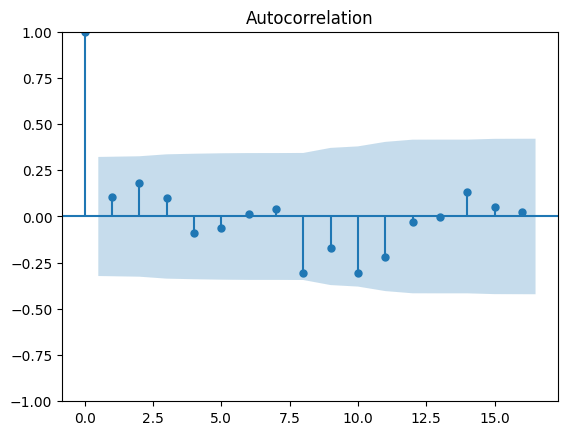

36   -6.906755
dtype: float64
ar.L1      0.611868
ma.L1     -0.479530
sigma2    46.324629
dtype: float64
Predicted next value: 36    0.303191
dtype: float64 manualy
Predicted next value: 37    0.303191
dtype: float64 model.forecast


In [11]:
##Testing for the ARMA model
# from scipy.special import expit, logit
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# test data
test_df = pd.DataFrame([0,1,1,1,1,1,1,0,1,0,0,1,0,0,0,0,0,1,1,0,1,0,1,1,1,1,0,0,0,0,0,1,0,0,0,1,0])

plot_acf(test_df)
plt.show()

transformed_series = pd.Series(logit(test_df.clip(1e-3, 1 - 1e-3)).values.ravel())
print(transformed_series[-1:])

m = SARIMAX(transformed_series, order=(1, 0, 1), enforce_invertibility=False)
model = m.fit(disp=True)

# model.plot_diagnostics(figsize=(12, 8))
# plt.show()

# model.summary()



##prediction of the next value
#Get the estimated parameters
params = model.params

print   (params)
# Get the lagged values from the transformed series
lagged_values = transformed_series[-1:]

# Compute the next value based on the estimated parameters and lagged values
next_value = params['ar.L1'] * lagged_values + params['ma.L1'] * model.resid[-1:]

print("Predicted next value:",expit(next_value), "manualy")

next_value = model.forecast(steps=1)
print("Predicted next value:", expit(next_value), "model.forecast")


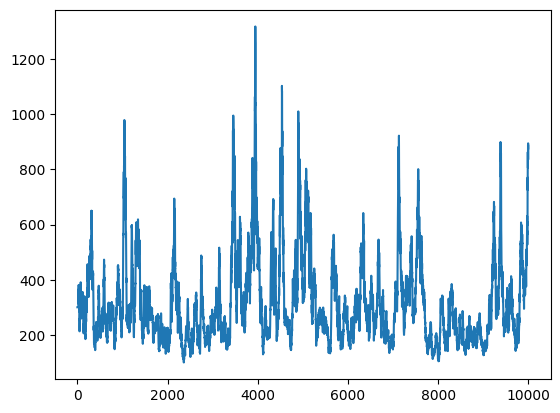

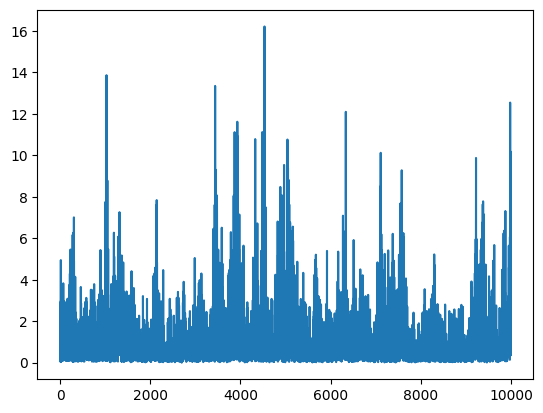

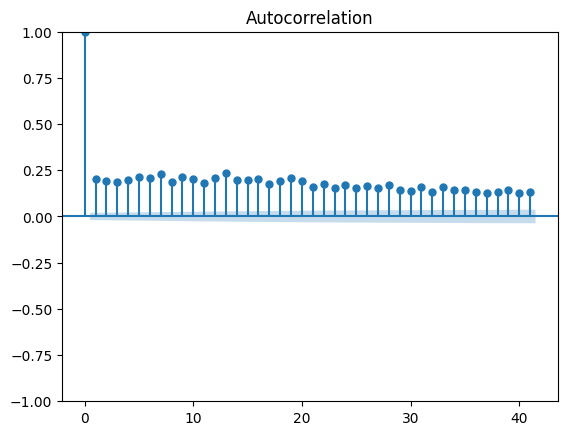

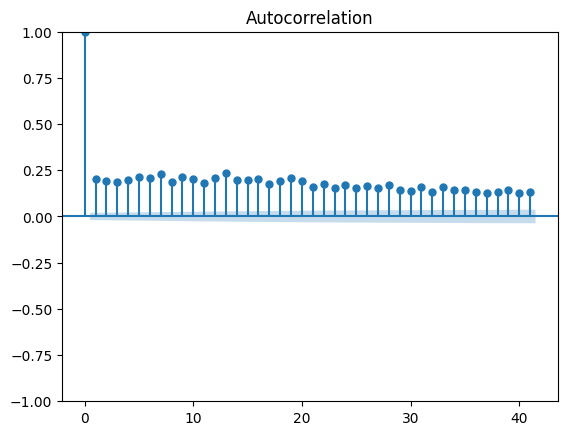

In [109]:
##Testing for transaction time herding
expon.stats(loc=0, scale=300, moments='m')

scale = 300
base_scale = 35


scaling_denominator = scale/(scale-base_scale)



past_window = 20
times = []
scales = [scale]
times.append(float(expon.rvs(loc = 0, scale=scale, size = 1)))

for i in range(10000):
    if i <= past_window:
        new_time = float(expon.rvs(loc = 0, scale=scale, size = 1))
        scales.append(scale)
    else:
        average_scale = np.mean(times[-past_window:])/scaling_denominator
        scales.append(base_scale + average_scale)

        new_time = float(expon.rvs(loc = 0, scale=base_scale, size = 1)) + float(expon.rvs(loc = 0, scale=average_scale, size = 1))



    times.append(new_time)

plt.plot(scales)
plt.show()


plt.plot(np.array(times)/300)
plt.show()

plot_acf(np.array(times))
#Ok, I think I have a basec prototype of herding behavior, next to implement it

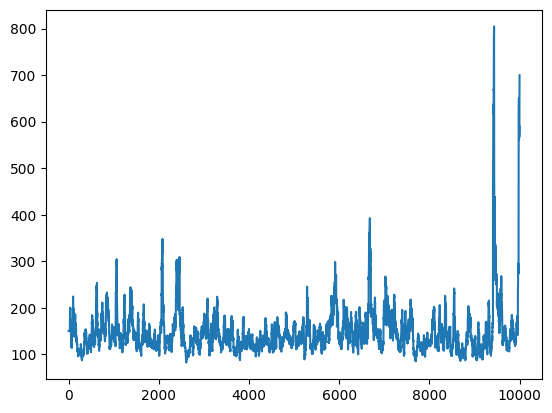

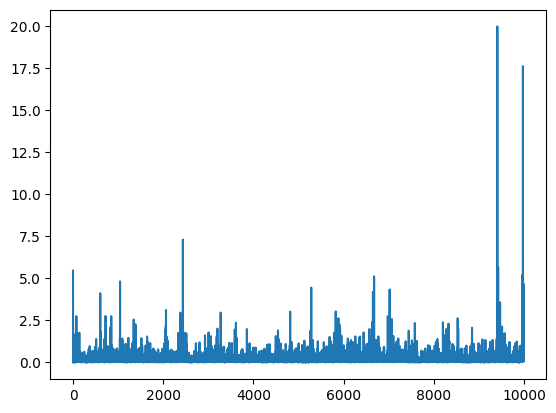

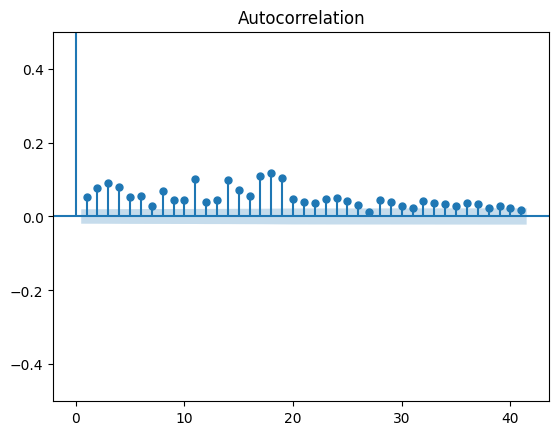

In [114]:
##Replicating the herding behavior for pareto distribution
#I have 2 models verified:        
    #r = pareto.rvs(b = 3, loc = -150, scale = 150, size=1) 
    #r = pareto.rvs(b = 4, loc = -250, scale = 250, size=1)

b = 3
scale = 150
base_scale = 50

#print(pareto.stats(b = b, loc = -scale, scale = scale, moments='m')) #In Pareto, the mean seems to be half of scale/-loc ... so I will compute mean from past observations and double it

# r = pareto.rvs(b = 3, loc = -500, scale = 500, size=100000) #It seems to work well - sum of two pareto dists is one pareto distribution with summed mean
# x = pareto.rvs(b = 3, loc = -500, scale = 500, size=100000) + pareto.rvs(b = 3, loc = -500, scale = 500, size=100000)
# print(np.mean(r), np.mean(x))



scaling_denominator = scale/(scale-base_scale) #the scaling denominator computes the part of the scale that does not come from the base scale

past_window = 25
times = []
scales = [scale]
times.append(float(pareto.rvs(b = b, loc = -scale, scale = scale, size=1)))

for i in range(10000):
    if i <= past_window:
        new_time = float(pareto.rvs(b = b, loc = -scale, scale = scale, size=1))
        scales.append(scale)
    else:
        average_scale = 2*np.mean(times[-past_window:])/scaling_denominator #the multiplication by 2 is here because in pareto dist, scale = mean*2

        new_time = float(pareto.rvs(b = b, loc = -base_scale, scale = base_scale, size=1)) + float(pareto.rvs(b = b, loc = -average_scale, scale = average_scale, size=1))
        scales.append(base_scale + average_scale)

    times.append(new_time) ##Ok, this seems to work well

plt.plot(scales)
plt.show()

plt.plot(np.array(times)/300)
plt.show()

fig = plot_acf(np.array(times))
plt.ylim([-0.5, 0.5])  
plt.show()

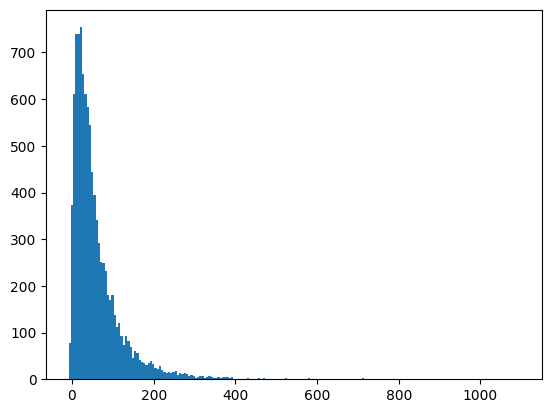

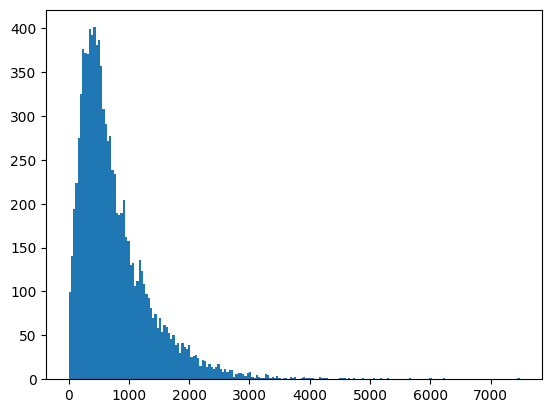

209


In [ ]:
##Testing the lognormal distribution -- looking for a suitable specification
#r = [x for x in lognorm.rvs(s = 0.85, loc = 0, scale = 150, size = 10000) if x >0]
r = lognorm.rvs(s = 0.8, loc = -10, scale = 50, size = 10000)
x = [x for x in exponnorm.rvs(K=4, loc=150, scale=150, size=10000) if x > 0]
#x = exponnorm.rvs(K=4, loc=150, scale=150, size=10000)


plt.hist(r, bins= 200)
plt.show()

plt.hist(x, bins= 200)
plt.show()


print(len(r[r<0]))




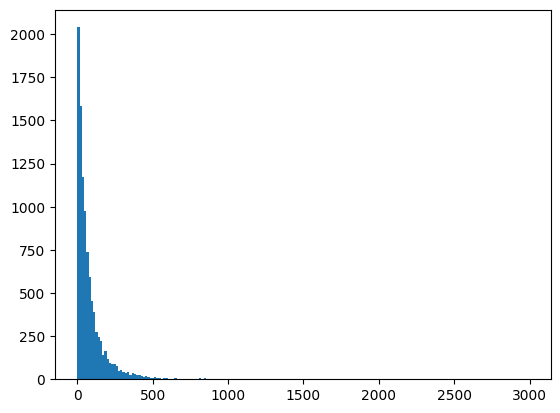

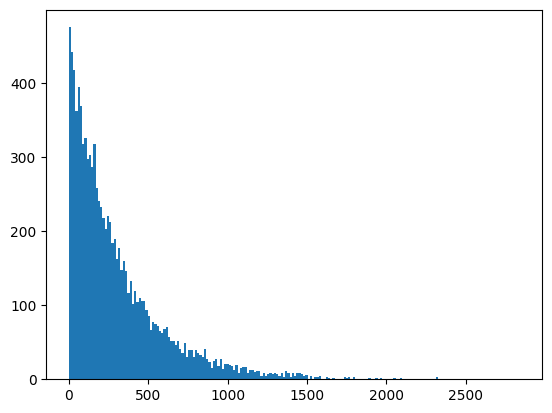

In [ ]:
##Testing the pareto distribution for random times -- looking for a suitable specification
#r = [x for x in lognorm.rvs(s = 0.85, loc = 0, scale = 150, size = 10000) if x >0]
#r = pareto.rvs(b = 3, loc = -150, scale = 150, size=10000)
r = pareto.rvs(b = 4, loc = -250, scale = 250, size=10000)
x = expon.rvs(loc = 0, scale=300, size = 10000)
#x = exponnorm.rvs(K=4, loc=150, scale=150, size=10000)


#'b': 3.0278565774644837, 'loc': -346.0979909671822, 'scale': 346.09


plt.hist(r, bins= 200)
plt.show()

plt.hist(x, bins= 200)
plt.show()